# French Motor Third Party Liability
## Poisson Regression with GLM and Neural Network


## 1 Introduction

Link to the original content can be found here: https://github.com/JSchelldorfer.


Previous notebooks can be found here:
1. Descriptive Analysis with matplotlib and seaborn: 

  https://colab.research.google.com/drive/1dvD1OaWKO9RyxtF78NRsEKbFrOr62xU8?usp=sharing
2. Poisson GLMs with statsmodels: 

  https://colab.research.google.com/drive/1kDodOz7_Fo3G7IT3X6XtvlX3_Jy5gwvu?usp=sharing



This notebook compare the goodness-of-fit of the following models:
1. A Poisson Regression using GLM
2. A Shallow Neural Network
3. A Deep Neural Network
4. A Deep Neural Network with Drop Out Layers

For more GLM examples please see the second notebook mention above.

## 2 Importing Data

Data used in the notebook has been downloaded from the following site: 

https://github.com/JSchelldorfer/DeepLearningWithActuarialApplications/blob/master/0_data/freMTPL2freq.RData

and subsequently converted into .csv format then uploaded to the environment.

You can download the .csv file used in the notebook from this link too:

https://drive.google.com/file/d/1J8xhBQZCI-22Do4TtL3dcExOgxqCbvCH/view?usp=sharing

Alternatively, you can fetch the same data from OpenML website using the following command:
```
from sklearn.datasets import fetch_openml
freq = fetch_openml(data_id=41214, as_frame=True).frame
```

*Note that modelled results will be slightly different to the JSchelldorfer's version if you use data downloaded directly from the OpenML website.*

In [ ]:
# If you have downloaded the csv from the google drive link and have it saved in your local drive,
# you can use the following command to upload it from local drive
# from google.colab import files
# uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import plotly.express as px 
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml
from keras.utils.layer_utils import count_params
from keras import layers
import keras
from keras.utils.vis_utils import plot_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline

In [ ]:
# Use this command to source data from your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
freq = pd.read_csv('gdrive/MyDrive/freq_data.csv')

## 3 Examining Data

Repeating from the previous notebooks, the definitions of each column in our dataset are:
- IDPol: Policy ID, used to link to severity data set
- ClaimNb: Claim numbers during exposure period
- Exposure: Period of exposure for a policy in year(s)
- VehPower: Car power, in categorical format
- VehAge: Car age, in continuous value format
- DrivAge: Driver’s age in years, in continuous value format
- BonusMalus: Bonus / Malus rating, <100 means bonus, >100 means malus, in continous value format
- VehBrand: Car brand, in categorical format
- VechGas: Fuel type, in categorical format
- Area: Density rating of the area car driver lives in, in categorical format
- Density: Density rating, number of inhabitants per km^2, in continous value format
- Region: Policy region in France, in categorical format

In [ ]:
freq.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb
0,1.0,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
1,3.0,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0,0
2,5.0,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0,0
3,10.0,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0,0
4,11.0,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0,0


We can see here that the default data type for `VehPower` is `int64`. We need it to be a categorical variable. We will change its data type in the next code chunk.

In [ ]:
freq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678007 non-null  float64
 1   Exposure    678007 non-null  float64
 2   Area        678007 non-null  object 
 3   VehPower    678007 non-null  int64  
 4   VehAge      678007 non-null  int64  
 5   DrivAge     678007 non-null  int64  
 6   BonusMalus  678007 non-null  int64  
 7   VehBrand    678007 non-null  object 
 8   VehGas      678007 non-null  object 
 9   Density     678007 non-null  int64  
 10  Region      678007 non-null  object 
 11  ClaimTotal  678007 non-null  float64
 12  ClaimNb     678007 non-null  int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 67.2+ MB


In [ ]:
freq.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimTotal,ClaimNb
count,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,6.780070e+05,678007.000000
mean,2.621857e+06,0.528547,6.454653,7.044218,45.499061,59.761588,1792.430975,8.816661e+01,0.038913
std,1.641789e+06,0.364081,2.050902,5.666235,14.137492,15.636700,3958.663031,5.822068e+03,0.204752
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
25%,1.157948e+06,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000
50%,2.272153e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
75%,4.046278e+06,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000
max,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,5.000000


## 4 Processing Data

When examining the data, we observed that there seems to be multiple claim records that might have arisen from the same policy.

A `GroupID` column is essential here such that we obtain sensible train-test split for our modelling.

You will see later we will use `sklearn.model_selection.GroupShuffleSplit` to perform train-test split on our modelling data.

Worth mentioning is that one of the common mistake is to do the data processing after train-test split. This will results in unfair comparison of the model performance.

In [ ]:
df_freq = freq.iloc[freq.drop(['IDpol','Exposure','ClaimNb'], axis=1).drop_duplicates().index]
df_freq = df_freq.reset_index(drop=True)
df_freq['GroupID'] = df_freq.index+1
df_freq = pd.merge(freq,df_freq, how='left')
df_freq['GroupID'] = df_freq['GroupID'].fillna(method='ffill')

We will also simplify the data for our GLM model. In particular, we will adjust the following columns:

- ClaimNb: cap at 4 claims
- VehAge: cap at 20 years
- DrivAge: cap at 90 years old
- BonusMalus: cap at 150, round to nearest integer
- Density: apply log
- Exposure: cap at 1 year

and subsequently add the following 'GLM' columns that will be used for model fitting:
- AreaGLM: convert alphabet into integer
- VehPowerGLM: cap at 9
- VehAgeGLM: create 3 bins
- DrivAgeGLM: create 7 bins

In [ ]:
df_freq['ClaimNb'] = df_freq['ClaimNb'].apply(lambda x: 4 if x > 4 else x)
df_freq['VehAge'] = df_freq['VehAge'].apply(lambda x: 20 if x > 20 else x)
df_freq['DrivAge'] = df_freq['DrivAge'].apply(lambda x: 90 if x > 90 else x)
df_freq['BonusMalus'] = df_freq['BonusMalus'].apply(lambda x: 150 if x > 150 else int(x))
df_freq['Density'] = df_freq['Density'].apply(lambda x: round(math.log(x), 2))
df_freq['Exposure'] = df_freq['Exposure'].apply(lambda x: 1. if x > 1 else x)
df_freq['AreaGLM']=df_freq['Area'].apply(lambda x: ord(x)-64)
df_freq['VehPowerGLM']=df_freq['VehPower'].apply(lambda x: 9 if x > 9 else x)
df_freq['VehPowerGLM']=df_freq['VehPowerGLM'].apply(lambda x: str(x))
df_freq['VehAgeGLM']=pd.cut(df_freq['VehAge'], bins=[0,1,10,np.inf], labels=[1,2,3], include_lowest=True)
df_freq['DrivAgeGLM']=pd.cut(df_freq['DrivAge'], bins=[18,21,26,31,41,51,71,np.inf], labels=[1,2,3,4,5,6,7], include_lowest=True)
df_freq['BonusMalusGLM'] = df_freq['BonusMalus']
df_freq['DensityGLM'] = df_freq['Density']

Re-examining the processed data.

In [ ]:
df_freq.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimTotal,ClaimNb,GroupID,AreaGLM,BonusMalusGLM,DensityGLM
count,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000,6.780070e+05,678007.000000,678007.000000,678007.000000,678007.000000,678007.000000
mean,2.621857e+06,0.528547,6.454653,6.976077,45.496811,59.757297,5.981576,8.816661e+01,0.038910,277296.885802,3.289692,59.757297,5.981576
std,1.641789e+06,0.364081,2.050902,5.398963,14.129919,15.607948,1.870569,5.822068e+03,0.204688,152393.589094,1.382689,15.607948,1.870569
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,50.000000,0.000000
25%,1.157948e+06,0.180000,5.000000,2.000000,34.000000,50.000000,4.520000,0.000000e+00,0.000000,151169.500000,2.000000,50.000000,4.520000
50%,2.272153e+06,0.490000,6.000000,6.000000,44.000000,50.000000,5.970000,0.000000e+00,0.000000,283376.000000,3.000000,50.000000,5.970000
75%,4.046278e+06,0.990000,7.000000,11.000000,55.000000,64.000000,7.410000,0.000000e+00,0.000000,405124.500000,4.000000,64.000000,7.410000
max,6.114330e+06,1.000000,15.000000,20.000000,90.000000,150.000000,10.200000,4.075401e+06,4.000000,534079.000000,6.000000,150.000000,10.200000


In [ ]:
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678007 entries, 0 to 678006
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   IDpol          678007 non-null  float64 
 1   Exposure       678007 non-null  float64 
 2   Area           678007 non-null  object  
 3   VehPower       678007 non-null  int64   
 4   VehAge         678007 non-null  int64   
 5   DrivAge        678007 non-null  int64   
 6   BonusMalus     678007 non-null  int64   
 7   VehBrand       678007 non-null  object  
 8   VehGas         678007 non-null  object  
 9   Density        678007 non-null  float64 
 10  Region         678007 non-null  object  
 11  ClaimTotal     678007 non-null  float64 
 12  ClaimNb        678007 non-null  int64   
 13  GroupID        678007 non-null  float64 
 14  AreaGLM        678007 non-null  int64   
 15  VehPowerGLM    678007 non-null  object  
 16  VehAgeGLM      678007 non-null  category
 17  DrivAgeGLM

In [ ]:
df_freq.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimTotal,ClaimNb,GroupID,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
0,1.0,0.10,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1.0,4,5,1,6,50,7.10
1,3.0,0.77,D,5,0,55,50,B12,Regular,7.10,R82,0.0,0,1.0,4,5,1,6,50,7.10
2,5.0,0.75,B,6,2,52,50,B12,Diesel,3.99,R22,0.0,0,2.0,2,6,2,6,50,3.99
3,10.0,0.09,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3.0,2,7,1,5,50,4.33
4,11.0,0.84,B,7,0,46,50,B12,Diesel,4.33,R72,0.0,0,3.0,2,7,1,5,50,4.33


In [ ]:
df_freq.columns

Index(['IDpol', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimTotal',
       'ClaimNb', 'GroupID', 'AreaGLM', 'VehPowerGLM', 'VehAgeGLM',
       'DrivAgeGLM', 'BonusMalusGLM', 'DensityGLM'],
      dtype='object')

## 5 GLM

With the data processed, we are ready for the modelling part.

The rest of the document focuses on using `statsmodel` package for GLM fitting.

#### 5.1 Some keywords...

There are a few key concepts you should be aware of about a GLM. Conveniently, most are covered in the IFoA SP8 Pricing paper.

- exponential family
- cummulant functions
- canonical link functions
- maximum likelihood estimator
- hessian matrix
- mean and variance functions
- design matrix
- deviance loss functions
- test statistics (AIC, F, chi-sqr)
- residuals plot
- goodness of fit tests (lift curve, gain curve)



#### 5.2 Train-Test Split

To do a stratified sampling / splitting data set based on user-defined column, we should use `GroupShuffleSplit` in the `sklearn` package.

In [ ]:
df_freq_glm = deepcopy(df_freq)
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=999)
split = splitter.split(df_freq_glm, groups=df_freq_glm['GroupID'])
train_inds, test_inds = next(split)
train = df_freq_glm.iloc[train_inds]
test = df_freq_glm.iloc[test_inds]

Check if the proportion of train set to test set is indeed 80:20.

In [ ]:
print(len(train)/len(df_freq_glm))
print(len(test)/len(df_freq_glm))

0.8001185828464897
0.1998814171535102


Check if the average claims frequencies are similar between train set and test set. They should be very similar, otherwise that means group shuffle has not been done appropriately.

In [ ]:
print(train['ClaimNb'].sum() / train['Exposure'].sum())
print(test['ClaimNb'].sum() / test['Exposure'].sum())

0.07347472468319734
0.07418268578040302


Check the sum of `Exposure` and count of `ClaimNb` in the train and test sets.

In [ ]:
print(train.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))
print('\n-------------------------\n')
print(test.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))

              Exposure ClaimNb
                   sum   count
ClaimNb                       
0        272996.206556  522589
1         12994.158010   18787
2           737.265479    1053
3            35.150000      51
4             2.500000       6

-------------------------

             Exposure ClaimNb
                  sum   count
ClaimNb                      
0        68093.440646  130480
1         3320.706553    4784
2          171.588219     245
3            7.220000      11
4            0.570000       1


### 5.3 Helper Functions

Define a Poisson Deviance function. So that this can be called upon after each GLM fit.

See the following site for details: 
https://en.wikipedia.org/wiki/Deviance_(statistics)


In [ ]:
def poisson_deviance(pred, obs):
  return 200*(sum(pred)-sum(obs)+sum(np.log((obs/pred)**(obs)))) / len(pred)

Define a function to store modelled results after each GLM and Neural Network fit.
The following will be displayed when the function is called:
- Model name
- Number of parameters
- Poisson deviance from the train set
- Poisson deviance from the test set
- Average frequency in the test set

This comparison table will be useful to compare any nested model. 

Poission deviance computed on both train and test set gives us a sense of whether train-test split has been fair. We would expect deviance calculated from the train set (in sample loss) to be lower than that calculated form the test set (out of sample loss).

In [ ]:
lst_model = []
lst_params = []
#lst_aic= []
lst_insampleloss = []
lst_outsampleloss = []
lst_avgfreq = []

def save_result(fittedmodel, model_desc, col_name):
  if 'GLM' in model_desc:
    train.insert(0,col_name,fittedmodel.predict(train, offset=np.log(train['Exposure'])))
    test.insert(0,col_name,fittedmodel.predict(test, offset=np.log(test['Exposure'])))
    lst_model.append(model_desc)
    lst_params.append(len(fittedmodel.params))
    #lst_aic.append((2*(fittedmodel.df_model+1) - 2*fittedmodel.llf))
    lst_insampleloss.append(poisson_deviance(train[col_name], train['ClaimNb']))
    lst_outsampleloss.append(poisson_deviance(test[col_name], test['ClaimNb']))
    lst_avgfreq.append(sum(test[col_name])/sum(test['Exposure']))
  if 'NN' in model_desc:
    fittedmodel.predict([train_nn[lst_nn_features],np.log(train_nn['Exposure'])])
    train_nn.insert(0,col_name,fittedmodel.predict([train_nn[lst_nn_features],np.log(train_nn['Exposure'])]))
    test_nn.insert(0,col_name,fittedmodel.predict([test_nn[lst_nn_features],np.log(test_nn['Exposure'])]))
    lst_model.append(model_desc)
    lst_params.append(count_params(fittedmodel.trainable_weights))
    lst_insampleloss.append(poisson_deviance(train_nn[col_name], train_nn['ClaimNb']))
    lst_outsampleloss.append(poisson_deviance(test_nn[col_name], test_nn['ClaimNb']))
    lst_avgfreq.append(sum(test_nn[col_name])/sum(test_nn['Exposure']))
  return pd.DataFrame({
      'Model': lst_model,
      'ParameterCount': lst_params,
      #'AIC': lst_aic,
      'InSampleLoss': lst_insampleloss,
      'OutSampleLoss': lst_outsampleloss,
      'AvgFrequency': lst_avgfreq
  })

The following function mimics what a `drop1` function in `R` is doing.

`R` is a clear win in this sense - you don't have to self-define a `drop1` function!

What it does is essentially re-fit the GLM by dropping one parameter at a time and create a table of test statistics - AIC, Deviance, Likelihood Ratio.

In [ ]:
def drop1(formula, model, data):
  x = [i for i in formula.split('~')[1].split('+')]
  drop1_stats = {}
  for k in range(1,len(x)+1):
      for variables in itertools.combinations(x, k):
          if len(variables) == len(x)-1:
            predictors = list(variables)
            i = True
            independent = ''
            for p in predictors:
                if i:
                    independent = p
                    i=False
                else:
                    independent+='+ {}'.format(p)
            regression = 'ClaimNb ~ {}'.format(independent)
            print('Dropping <'+[i for i in x if i not in predictors][0]+'> from the model and recalculate statistics ... \n')
            res =  smf.glm(formula=regression, data=data, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(data['Exposure'])).fit()
            drop1_stats[[i for i in x if i not in predictors][0]] = (2*(k+1) - 2*res.llf,
                                                               res.deviance,
                                                               res.deviance - model.deviance,
                                                               res.df_model,
                                                               #1-stats.chi2.cdf(res.deviance - model.deviance, res.df_model)   
                                                               )
  df_out = pd.DataFrame(drop1_stats).T
  df_out.columns = ['AIC','Deviance','LRT','DoF']
  return df_out

###5.4 Model 1: GLM

In [ ]:
formula0 = "ClaimNb ~ AreaGLM + VehPowerGLM +  C(VehAgeGLM, Treatment(reference=2)) + BonusMalusGLM + VehBrand +VehGas + DensityGLM + C(Region, Treatment(reference='R24')) + DrivAge + np.log(DrivAge) + I(DrivAge**2) + I(DrivAge**3) + I(DrivAge**4)"
glm0 = smf.glm(formula=formula0, data=train, family=sm.families.Poisson(link=sm.families.links.log()), offset=np.log(train['Exposure'])).fit()

In [ ]:
print(glm0.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               542486
Model:                            GLM   Df Residuals:                   542439
Model Family:                 Poisson   Df Model:                           46
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85566.
Date:                Wed, 04 May 2022   Deviance:                   1.3063e+05
Time:                        11:06:26   Pearson chi2:                 8.97e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
# Need sufficient memory to run this.
# df_drop1_glm0 = drop1(formula0, glm0, train)
# df_drop1_glm0

In [ ]:
save_result(glm0,'Model 1: GLM','FittedGLM')

,Model,ParameterCount,InSampleLoss,OutSampleLoss,AvgFrequency
0,Model 1: GLM,48,24.080546,24.196635,0.073726


##6 Neural Networks

Data need to be processed differently from the way shown above for GLMs. The choice of scale of the feature components in network modelling may substantially influence the fitting procedure of the predictive model. Therefore, data pre-processing needs careful consideration.

We treat categorical and continuous features separately.



*Categorical Features*

We need to transform categorical features into numerical format. There are two ways to do it: dummy coding or one-hot encoding. For dummy coding one label is chosen as reference, whereas one-hot encoding does not pick a reference label. In other words, for a feature with 10 different lavels, dummy coding will result in a 10-dimensional feature vectors whereas one-hot encoding will result in 11-dimensional feature vectors.

The key difference between the dummy coding and one-hot encoding is that the former leads to full rank design matrices, whereas the latter does not. This implies that under one-hot encoding there are identifiablity issues in parameterisation.

In network modelling, identifiability is less important as we typically work in over-parameterised non-convex optimisation problems. However, this will be an issue for GLMs because we normally try to solve a convex optimisation problem, where full rank property is important to efficiency and the unique solution.

*Continuous Features*

In theory, we do not have to pre-process continuous features if we choose a sufficiently rich network, because the network may take care of feature components living on different scales. In practice, we pre-process continuous features so that they are sufficiently equally distributed across scale. The adjustment is needed such that gradient descent can work properly, i.e. not trapped in local minima.

A popular transformation is the MinMaxScaler. 
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

`
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
`

This will result in x values ranging from -1 to +1.


*Binary Features*

Convert all binary features into -0.5 (False) or +0.5 (True).

*Summary*

As a rule of thumb, one could formulate the pre-processing as:
- continuous --> scale to [-1,+1] if no outliers
- binary --> set to [-0/5,+0/5]
- categorical --> one-hot encode, dummy code

###6.1 Pre-processing

For our French Motor Third Party Liability example, we will be performing the following conversion:
- Dummy code: VehBrand and Region
- MinMaxScaler: Area, VehPower, VehAge, DrivAge, BonusMalus, Density
- Binary adjustments: VehGas

In [ ]:
df_freq_nn = deepcopy(df_freq)
lst_dummy_code = ['VehBrand','Region']
dummies = pd.get_dummies(df_freq_nn[lst_dummy_code], drop_first=True).rename(columns=lambda x: 'Category_' + str(x))
df_freq_nn = pd.concat([df_freq_nn, dummies], axis=1)
scaler = MinMaxScaler()
lst_minmaxscale = ['AreaGLM', 'VehPowerGLM', 'VehAgeGLM','DrivAgeGLM','BonusMalusGLM','DensityGLM']
df_freq_nn[['Scaled_'+i for i in lst_minmaxscale]] = scaler.fit_transform(df_freq_nn[lst_minmaxscale])
df_freq_nn['Scaled_VehGas']=np.where(df_freq_nn['VehGas']=='Regular',0.5,-0.5)

In [ ]:
df_freq_nn.columns

Index(['IDpol', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimTotal',
       'ClaimNb', 'GroupID', 'AreaGLM', 'VehPowerGLM', 'VehAgeGLM',
       'DrivAgeGLM', 'BonusMalusGLM', 'DensityGLM', 'Category_VehBrand_B10',
       'Category_VehBrand_B11', 'Category_VehBrand_B12',
       'Category_VehBrand_B13', 'Category_VehBrand_B14',
       'Category_VehBrand_B2', 'Category_VehBrand_B3', 'Category_VehBrand_B4',
       'Category_VehBrand_B5', 'Category_VehBrand_B6', 'Category_Region_R21',
       'Category_Region_R22', 'Category_Region_R23', 'Category_Region_R24',
       'Category_Region_R25', 'Category_Region_R26', 'Category_Region_R31',
       'Category_Region_R41', 'Category_Region_R42', 'Category_Region_R43',
       'Category_Region_R52', 'Category_Region_R53', 'Category_Region_R54',
       'Category_Region_R72', 'Category_Region_R73', 'Category_Region_R74',
       'Category_Region_R82', 'Category_Region_R83', 'Cat

Now, create a list to store all of the features to be included in network modelling.

In [ ]:
lst_nn_features = [col for col in df_freq_nn.columns if col.startswith('Category') or col.startswith('Scaled')]

Similar to GLM section, we utilise `GroupShuffleSplit` to create train test split.

In [ ]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=2, random_state=999)
split = splitter.split(df_freq_nn, groups=df_freq_nn['GroupID'])
train_inds, test_inds = next(split)
train_nn = df_freq_nn.iloc[train_inds]
test_nn = df_freq_nn.iloc[test_inds]

Checking key stats post-split.

In [ ]:
print(len(train_nn)/len(df_freq_nn))
print(len(test_nn)/len(df_freq_nn))

0.8001185828464897
0.1998814171535102


In [ ]:
print(train_nn['ClaimNb'].sum() / train_nn['Exposure'].sum())
print(test_nn['ClaimNb'].sum() / test_nn['Exposure'].sum())

0.07347472468319734
0.07418268578040302


In [ ]:
print(train_nn.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))
print('\n-------------------------\n')
print(test_nn.groupby(by=['ClaimNb']).agg({'Exposure':['sum'],'ClaimNb':['count']}))

              Exposure ClaimNb
                   sum   count
ClaimNb                       
0        272996.206556  522589
1         12994.158010   18787
2           737.265479    1053
3            35.150000      51
4             2.500000       6

-------------------------

             Exposure ClaimNb
                  sum   count
ClaimNb                      
0        68093.440646  130480
1         3320.706553    4784
2          171.588219     245
3            7.220000      11
4            0.570000       1


###6.2 Designing Neural Networks

The choice of a particular network architechture and its calibration invovle many steps. In each of these steps, the modeller has to make certain decisions, and it may require that each of these decisions is revised several times to get the best predictive model.

This notebook is not intended to discuss the best way to select these hyperparameters. We will include links to other literatures that discuss this topics in details at the end of this notebook.

The choise involve:
- data cleaning & processing
- choice of loss fundtion / objective function and performance measure for model calibrarion
- number of hidden layers
- number of neurons in the hidden layers
- choice of activation function
- optimisation algorithm:
  - initialisation of algorithm
  - random batches of data
  - stopping, number of iterations, number of epochs etc.
  - parameters like learning rates, momentum parameters etc.
- normalisation layers, dropout rates
- regularisation like LASSO or ridge regression etc.

These choices correspond to the modelling cycle that is typically performed in statistical applications, the final validation step is not mentioned above.

*Gradient Descent Algorithms*

There are several optimisers available to find the solution to a neural network, some of which are:
- `sgd`: stochastic gradient descent
- `adagrad`: adapted graduent descent
- `adadelta`: modified version of adagrad that overcomes some deficiencies of the latter
- `rmsprop`: root mean squared propagation
- `adam`: adaptive moment estimation
- `nadam`: Nesterov accelerated version of adam

More info can be foudn here:
https://ruder.io/optimizing-gradient-descent/

In this notebook, we have used `nadam` throughout as studies show it is a good candidate to be used.


*Epochs and batches*

Epochs indicates how many times we go through the entire learning data, and batch size indicates the size of the subsamples considered in each Gradient Descent Method (GDM) step. Thus, if the batch size is equal to the number of observations `n` we do exactly one GDM step in one epoch, if the batch size is equal to `1` then we do `n` GDM steps in one epoch until we have seen the entire learning data D. 

Note that smaller batches are needed for big data because it is not feasible to simultaneously calculate the gradient on all data efficiently if we have many observations. Therefore, we partition the entire data at random into (mini-) batches in the application of the GDM. Note that this partitioning of the data is of particular interest if we work with big data because it allows us to explore the data sequentially.

Concretely, for the maximal batch size `n` we can do exactly one GDM step in one epoch, for batch size `k` we can do `n/k` GDM steps in one epoch. For the maximal batch size we need to calculate the gradient on the entire data. The latter is, of course, much faster but on the other hand we need to calculate `n/k` gradients to run through the entire data (in an epoch).

The partitioning of the data into batches is done at random, and it may happen that several potential outliers lie in the same batch. This happens especially if the chosen batch size is small and the expected frequency is low (class imbalance problem).

*Initialisation*

A simple way to bring the initial network onto the right price level is to embed the homogeneous model into the neural network. 

This can be achieved by setting the output weights of the neurons equal to zero, and by initialising the output intercept to the homogeneous model. This is obtained subsequently by the code
part defining the weights.

In [ ]:
lambda_hom = train_nn['ClaimNb'].sum() / train_nn['Exposure'].sum()
np.log(lambda_hom)

-2.6108138137655326

*Activation Function*

Again, there are multiple choices for activation functions, to name a few:
- sigmoid function
- tanh
- step
- relu

The particular choice of the activation function may matter: calibration of deep networks may be slightly simpler if we choose the hyperbolic tangent activation because this will guarantee that all hidden neurons are in [−1, +1], which is the domain of the main activation of the neurons in the next layer.

The step function activation is useful for theoretical considerations. From a practical point of view it is less
useful because it is not differentiable and difficult to calibrate. Moreover, the discontinuity also implies that neighboring feature components may have rather different regression function responses: if the step function jumps, say, between driver’s ages 48 and 49, then these two driver’s ages may have a rather different insurance
premium. For these reasons we do not pursue with the step function activation here.

We remark that the ReLU activation function often leads to sparsity in deep network activations because some neurons remain unactivated for the entire input. Such an effect may be wanted because it reduces the complexity of the regression model, but it can also be an undesired side effect because it may increase the difficulty in model calibration because of more vanishing gradients. Moreover, ReLU may lead to arbitrarily large activations in neurons because it is an unbounded activation function, this may be an unwanted effect because it may need re-scaling of activations to the main domain around the origin.

More info on: https://www.v7labs.com/blog/neural-networks-activation-functions


###6.3 Model 2: Shallow Plain Network

This is the simplest form of neural network, a so called shallow plain vanilla neural network.

We choose a network with 1 hidden layer and 20 neurons.

Here is how it can be complied in python.

Further info can be found here:
https://keras.io/guides/functional_api/

In [ ]:
input1 = keras.Input(shape=(38,), name='design')
input2 = keras.Input(shape=(1,), name='logvol')
initializer = keras.initializers.Zeros()
layer1 = layers.Dense(20, activation='tanh', name='layer1', kernel_initializer=initializer)
x1 = layer1(input1)
initializer = keras.initializers.Constant(np.log(lambda_hom))
layer2 = layers.Dense(1, activation='linear', name='network', kernel_initializer=initializer)
x2 = layer2(x1)
added = keras.layers.Add(name='add')([x2,input2])
initializer = keras.initializers.Zeros()
outputs = layers.Dense(1, activation='exponential', name='response', kernel_initializer=initializer)(added)
model_sh = keras.Model(inputs=[input1,input2], outputs=outputs)
model_sh.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 design (InputLayer)            [(None, 38)]         0           []                               
                                                                                                  
 layer1 (Dense)                 (None, 20)           780         ['design[0][0]']                 
                                                                                                  
 network (Dense)                (None, 1)            21          ['layer1[0][0]']                 
                                                                                                  
 logvol (InputLayer)            [(None, 1)]          0           []                               
                                                                                              

Now we complie the model using Poisson loss function as objective function, and `nadam` as the optimiser.

In [ ]:
model_sh.compile(loss='poisson', optimizer='nadam')

The neural network we complied can be visualised using the following command.

The first layer is all of our input features, i.e. VehBrand, Area, DrivAge etc.

Then we have one hidden layer with 20 neurons, which takes 38-dimensional inputs and produces 1-dimensional outputs.

We have a second input layer called logvol that is added with the output from our hidden layer to produce final result - claims frequency.

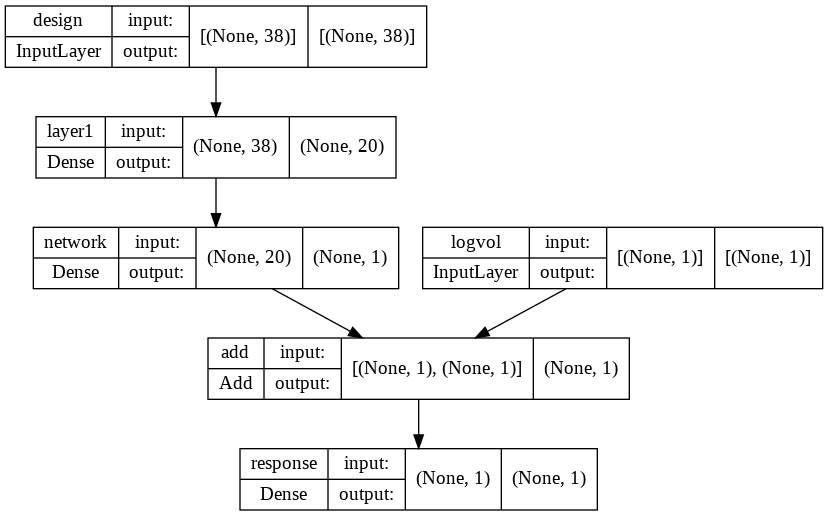

In [ ]:
plot_model(model_sh, show_shapes=True, show_layer_names=True)

Starting to train our plain vanilla neural network...

If validation_split > 0, then the training set is further subdivided into a new training and a validation set. The new training set is used for fitting the model and the validation set is used for (out-of-sample) validation.

We emphasize that the validation set is chosen disjointly from the test data, as this latter data may still be used later for the choice of the optimal model (if, for instance, we need to decide between several networks).

With validation_split = 0.2 we split the learning data 8:2 into training set and validation set. We fit the network on the training set and we out-of-sample validate it on the validation set.

In [ ]:
history_sh = model_sh.fit(
    x=[train_nn[lst_nn_features],np.log(train_nn['Exposure'])], 
    y=train_nn['ClaimNb'], 
    epochs=300, batch_size=10000, validation_split=0.2, verbose=1)

Epoch 1/300
44/44 [==============================] - 2s 15ms/step - loss: 0.7858 - val_loss: 0.4360
Epoch 2/300
44/44 [==============================] - 0s 10ms/step - loss: 0.2892 - val_loss: 0.1829
Epoch 3/300
44/44 [==============================] - 0s 10ms/step - loss: 0.1871 - val_loss: 0.1510
Epoch 4/300
44/44 [==============================] - 0s 11ms/step - loss: 0.1750 - val_loss: 0.1452
Epoch 5/300
44/44 [==============================] - 0s 10ms/step - loss: 0.1731 - val_loss: 0.1436
Epoch 6/300
44/44 [==============================] - 0s 11ms/step - loss: 0.1726 - val_loss: 0.1429
Epoch 7/300
44/44 [==============================] - 0s 10ms/step - loss: 0.1723 - val_loss: 0.1425
Epoch 8/300
44/44 [==============================] - 0s 11ms/step - loss: 0.1720 - val_loss: 0.1422
Epoch 9/300
44/44 [==============================] - 0s 10ms/step - loss: 0.1717 - val_loss: 0.1419
Epoch 10/300
44/44 [==============================] - 0s 10ms/step - loss: 0.1714 - val_loss: 0.1416

In [ ]:
save_result(model_sh,'Model 2: NN - Shallow Plain Network','FittedshNN')

,Model,ParameterCount,InSampleLoss,OutSampleLoss,AvgFrequency
0,Model 1: GLM,48,24.080546,24.196635,0.073726
1,Model 2: NN - Shallow Plain Network,803,23.954045,24.061446,0.073552


The `history` object stores all model fitting history. We can plot these loss values to see how they converge during the gradient descent process.

In [ ]:
history_sh.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
df_history_sh = pd.DataFrame(history_sh.history)
fig = px.line(df_history_sh, x=history_sh.epoch, y=['loss','val_loss'], title='Model Accuracy',markers=True)
fig.show()

Training and validation loss decreases with every epoch. This is what we would expect when running a gradient-descent optimisation - the quantity you're trying to minimise should be less with every iteration.

###6.4 Model 3: Deep Plain Network

Now, let's fit a deep neural network. We choose a network with 3 hidden layers with 20, 15, and 10 neurons.

Contruction in python looks like:

In [ ]:
input1 = keras.Input(shape=(38,), name='design')
input2 = keras.Input(shape=(1,), name='logvol')
initializer = keras.initializers.Zeros()
layer1 = layers.Dense(20, activation='tanh', name='layer1', kernel_initializer=initializer)
x1 = layer1(input1)
layer2 = layers.Dense(15, activation='tanh', name='layer2', kernel_initializer=initializer)
x2 = layer2(x1)
layer3 = layers.Dense(10, activation='tanh', name='layer3', kernel_initializer=initializer)
x3 = layer3(x2)

initializer = keras.initializers.Constant(np.log(lambda_hom))
layer4 = layers.Dense(1, activation='linear', name='network', kernel_initializer=initializer)
x4 = layer4(x3)

added = keras.layers.Add(name='add')([x4,input2])
initializer = keras.initializers.Zeros()
outputs = layers.Dense(1, activation='exponential', name='response', kernel_initializer=initializer)(added)
model_dp = keras.Model(inputs=[input1,input2], outputs=outputs)
model_dp.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 design (InputLayer)            [(None, 38)]         0           []                               
                                                                                                  
 layer1 (Dense)                 (None, 20)           780         ['design[0][0]']                 
                                                                                                  
 layer2 (Dense)                 (None, 15)           315         ['layer1[0][0]']                 
                                                                                                  
 layer3 (Dense)                 (None, 10)           160         ['layer2[0][0]']                 
                                                                                            

In [ ]:
model_dp.compile(loss='poisson', optimizer='nadam')

Illustrating in a graph.

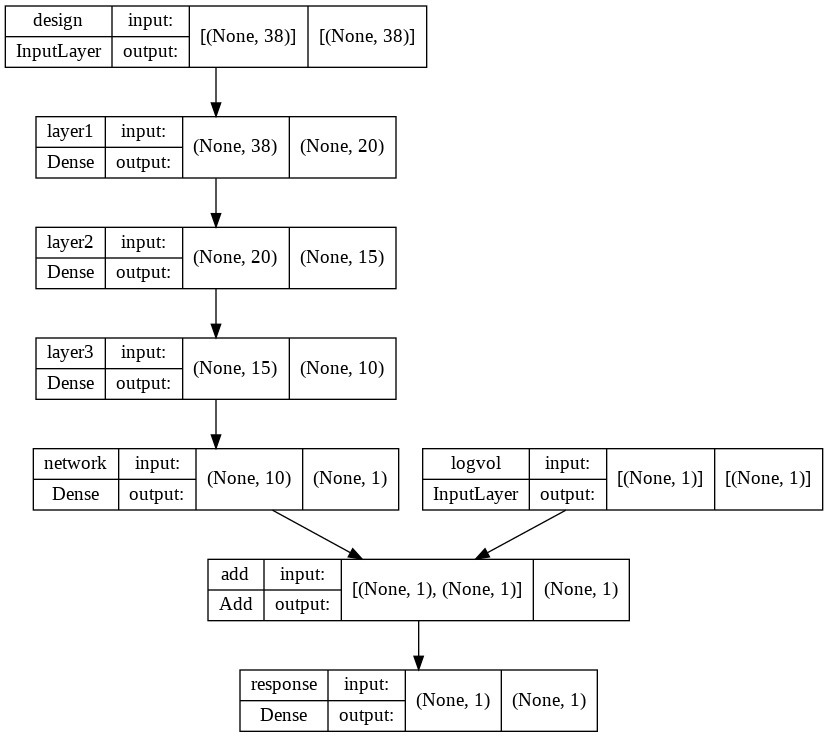

In [ ]:
plot_model(model_dp, show_shapes=True, show_layer_names=True)

Fitting and storing histories.

In [ ]:
history_dp = model_dp.fit(
    x=[train_nn[lst_nn_features],np.log(train_nn['Exposure'])], 
    y=train_nn['ClaimNb'], 
    epochs=300, batch_size=10000, validation_split=0.2, verbose=1)

Epoch 1/300
44/44 [==============================] - 2s 20ms/step - loss: 0.9437 - val_loss: 0.8466
Epoch 2/300
44/44 [==============================] - 1s 16ms/step - loss: 0.7334 - val_loss: 0.5880
Epoch 3/300
44/44 [==============================] - 1s 16ms/step - loss: 0.4932 - val_loss: 0.3782
Epoch 4/300
44/44 [==============================] - 1s 15ms/step - loss: 0.3312 - val_loss: 0.2591
Epoch 5/300
44/44 [==============================] - 1s 16ms/step - loss: 0.2461 - val_loss: 0.1996
Epoch 6/300
44/44 [==============================] - 1s 15ms/step - loss: 0.2050 - val_loss: 0.1702
Epoch 7/300
44/44 [==============================] - 1s 15ms/step - loss: 0.1853 - val_loss: 0.1553
Epoch 8/300
44/44 [==============================] - 1s 15ms/step - loss: 0.1758 - val_loss: 0.1476
Epoch 9/300
44/44 [==============================] - 1s 15ms/step - loss: 0.1712 - val_loss: 0.1435
Epoch 10/300
44/44 [==============================] - 1s 16ms/step - loss: 0.1690 - val_loss: 0.1412

In [ ]:
save_result(model_dp,'Model 3: NN - Deep Network','FitteddpNN')

,Model,ParameterCount,InSampleLoss,OutSampleLoss,AvgFrequency
0,Model 1: GLM,48,24.080546,24.196635,0.073726
1,Model 2: NN - Shallow Plain Network,803,23.954045,24.061446,0.073552
2,Model 3: NN - Deep Network,1268,24.877304,24.947378,0.078312


In [ ]:
df_history_dp = pd.DataFrame(history_dp.history)
fig = px.line(df_history_dp, x=history_dp.epoch, y=['loss','val_loss'], title='Model Accuracy',markers=True)
fig.show()

###6.5 Model 5: Deep Dropout Network

Now, let's fit a deep neural network with drop out layers.

Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.

Contruction in python looks like:

In [ ]:
input1 = keras.Input(shape=(38,), name='design')
input2 = keras.Input(shape=(1,), name='logvol')
initializer = keras.initializers.Zeros()
layer1 = layers.Dense(20, activation='tanh', name='layer1', kernel_initializer=initializer)
x1 = layer1(input1)
layer2 = layers.Dropout(0.05)
x2 = layer2(x1)
layer3 = layers.Dense(15, activation='tanh', name='layer2', kernel_initializer=initializer)
x3 = layer3(x2)
layer4 = layers.Dropout(0.05)
x4 = layer4(x3)
layer5 = layers.Dense(10, activation='tanh', name='layer3', kernel_initializer=initializer)
x5 = layer5(x4)
layer6 = layers.Dropout(0.05)
x6 = layer6(x5)

initializer = keras.initializers.Constant(np.log(lambda_hom))
layer7 = layers.Dense(1, activation='linear', name='network', kernel_initializer=initializer)
x7 = layer7(x6)

added = keras.layers.Add(name='add')([x7,input2])
initializer = keras.initializers.Zeros()
outputs = layers.Dense(1, activation='exponential', name='response', kernel_initializer=initializer)(added)
model_dr = keras.Model(inputs=[input1,input2], outputs=outputs)
model_dr.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 design (InputLayer)            [(None, 38)]         0           []                               
                                                                                                  
 layer1 (Dense)                 (None, 20)           780         ['design[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 20)           0           ['layer1[0][0]']                 
                                                                                                  
 layer2 (Dense)                 (None, 15)           315         ['dropout[0][0]']                
                                                                                            

In [ ]:
model_dr.compile(loss='poisson', optimizer='nadam')

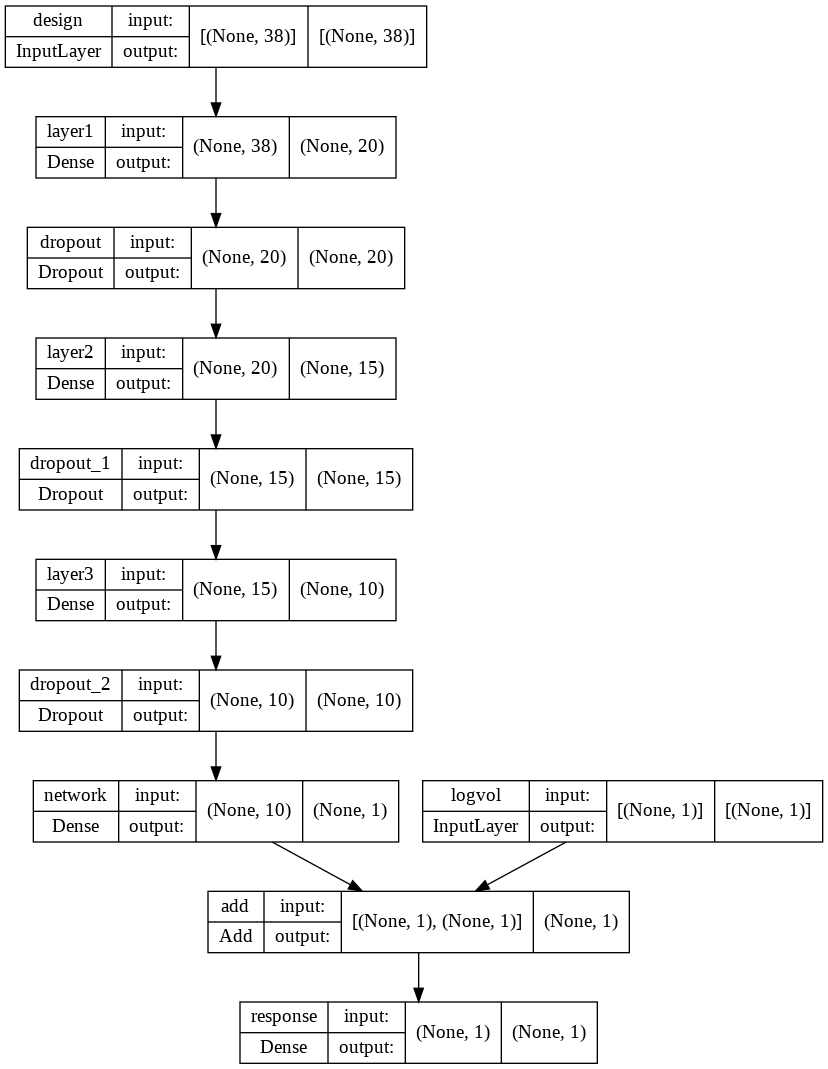

In [ ]:
plot_model(model_dr, show_shapes=True, show_layer_names=True)

In [ ]:
history_dr = model_dr.fit(
    x=[train_nn[lst_nn_features],np.log(train_nn['Exposure'])], 
    y=train_nn['ClaimNb'], 
    epochs=300, batch_size=10000, validation_split=0.2, verbose=1)

Epoch 1/300
44/44 [==============================] - 3s 26ms/step - loss: 0.9436 - val_loss: 0.8465
Epoch 2/300
44/44 [==============================] - 1s 22ms/step - loss: 0.7335 - val_loss: 0.5881
Epoch 3/300
44/44 [==============================] - 1s 21ms/step - loss: 0.4938 - val_loss: 0.3784
Epoch 4/300
44/44 [==============================] - 1s 21ms/step - loss: 0.3321 - val_loss: 0.2593
Epoch 5/300
44/44 [==============================] - 1s 21ms/step - loss: 0.2472 - val_loss: 0.1997
Epoch 6/300
44/44 [==============================] - 1s 21ms/step - loss: 0.2062 - val_loss: 0.1703
Epoch 7/300
44/44 [==============================] - 1s 21ms/step - loss: 0.1864 - val_loss: 0.1554
Epoch 8/300
44/44 [==============================] - 1s 23ms/step - loss: 0.1769 - val_loss: 0.1476
Epoch 9/300
44/44 [==============================] - 1s 22ms/step - loss: 0.1722 - val_loss: 0.1435
Epoch 10/300
44/44 [==============================] - 1s 22ms/step - loss: 0.1698 - val_loss: 0.1412

In [ ]:
save_result(model_dr,'Model 4: NN - Deep Network with Drop Out','FitteddrNN')

,Model,ParameterCount,InSampleLoss,OutSampleLoss,AvgFrequency
0,Model 1: GLM,48,24.080546,24.196635,0.073726
1,Model 2: NN - Shallow Plain Network,803,23.954045,24.061446,0.073552
2,Model 3: NN - Deep Network,1268,24.877304,24.947378,0.078312
3,Model 4: NN - Deep Network with Drop Out,1268,24.863164,24.934730,0.075600


In [ ]:
df_history_dr = pd.DataFrame(history_dr.history)
fig = px.line(df_history_dr, x=history_dr.epoch, y=['loss','val_loss'], title='Model Accuracy',markers=True)
fig.show()

## 7 Compare Different Models

The following function uses `plotly` package to graph model predictions by different dimensions.

In [ ]:
test_comb = pd.concat([test,test_nn[['FittedshNN','FitteddpNN','FitteddrNN']]] ,axis=1)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
def plot_freq_by_models(dimension):
  temp = test_comb.groupby(by=[dimension]).agg(
      {'ClaimNb':sum,
       'Exposure':sum,
       'FittedGLM':sum,
       'FittedshNN':sum,
       'FitteddpNN':sum,
       'FitteddrNN':sum
      }
  ).reset_index()
  temp['TestSetObs'] = temp['ClaimNb'] / temp['Exposure']
  temp['GLM'] = temp['FittedGLM'] / temp['Exposure']
  temp['ShallowNN'] = temp['FittedshNN'] / temp['Exposure']
  temp['DeepNN'] = temp['FitteddpNN'] / temp['Exposure']
  temp['DeepDropNN'] = temp['FitteddrNN'] / temp['Exposure']
  temp.drop(['ClaimNb','FittedGLM','FittedshNN','FitteddpNN','FitteddrNN'], axis=1, inplace=True)
  #temp.drop(['ClaimNb','Exposure','FittedGLM','FittedshNN','FitteddpNN','FitteddrNN'], axis=1, inplace=True)
  #fig = go.Figure()
  #fig.add_trace(go.Scatter(x=temp[dimension], y=temp['TestSetObs'], name='TestSetObs'))
  #fig.add_trace(go.Bar(x=temp[dimension], y=temp['Exposure'], name='Exposure'))
  # Create figure with secondary y-axis
  fig = make_subplots(specs=[[{"secondary_y": True}]])
  fig.add_trace(
      go.Scatter(x=temp[dimension], y=temp['TestSetObs'], name='TestSetObs'),
      secondary_y=False)
  fig.add_trace(
      go.Scatter(x=temp[dimension], y=temp['GLM'], name='GLM'),
      secondary_y=False)
  fig.add_trace(
      go.Scatter(x=temp[dimension], y=temp['ShallowNN'], name='ShallowNN'),
      secondary_y=False)
  fig.add_trace(
      go.Scatter(x=temp[dimension], y=temp['DeepNN'], name='DeepNN'),
      secondary_y=False)
  fig.add_trace(
      go.Scatter(x=temp[dimension], y=temp['DeepDropNN'], name='DeepDropNN'),
      secondary_y=False)
  fig.add_trace(
      go.Bar(x=temp[dimension],y=temp['Exposure'], name='Exposure', opacity=0.4),
      secondary_y=True
  )
  fig.update_layout(
      title_text='Freq by '+dimension
      
  )
  fig.show()

The results of the various models are as follow:

In [ ]:
pd.DataFrame({
      'Model': lst_model,
      'ParameterCount': lst_params,
      'InSampleLoss': lst_insampleloss,
      'OutSampleLoss': lst_outsampleloss,
      'AvgFrequency': lst_avgfreq
  })

,Model,ParameterCount,InSampleLoss,OutSampleLoss,AvgFrequency
0,Model 1: GLM,48,24.080546,24.196635,0.073726
1,Model 2: NN - Shallow Plain Network,803,23.954045,24.061446,0.073552
2,Model 3: NN - Deep Network,1268,24.877304,24.947378,0.078312
3,Model 4: NN - Deep Network with Drop Out,1268,24.863164,24.934730,0.075600


We can observe that:
- The shallow plain network results in lowest in and out of sample loss. This is inconsistent with the findings that JSchelldorfer has where his model 3 & 4 resulted in greatest fit despite having the same network strucutre. (Unless there is mistake in this notebook...)
- The fitted average claim frequency differs between the neural network models. This is different when comparing GLM’s (see the previous notebook) where the predicted claim frequency is the same for all models. This is the so called bias regularization issue of neural networks
- We see that the freqMTPL2freq dataset is maybe not ideal and not representative for a standard primary insurance pricing dataset, due to:
  - The performance of the various models is quite similar and there are not many areas with highly different predictions.
  - The marginal predicted frequencies do not vary much across the various categorical feature levels.
  - The goal of the tutorial is more to demonstrate the techniques and compare them rather to nicely identify important features.

In [ ]:
plot_freq_by_models('Area')

In [ ]:
plot_freq_by_models('VehPower')

In [ ]:
plot_freq_by_models('VehBrand')

In [ ]:
plot_freq_by_models('DrivAge')

In [ ]:
plot_freq_by_models('Region')

In [ ]:
plot_freq_by_models('VehAge')

In [ ]:
plot_freq_by_models('BonusMalus')

In [ ]:
plot_freq_by_models('VehGas')

## 8 Conclusions


With fitting neural networks, there are a couple of questions arising, and we like to share some of our experience here:
- The choice of the architecture can be considered more as art than science
- Neural networks move the challenge of feature engineering (which the network learns) to the challenge of selecting the architecture.
- There are a few rules of thumb on the architecture:
  - For structured data, only 3-5 layers are required, more layers do not improve the accuracy further
  - For finding interactions, the third and higher layers are “considering” them. The first two are for the “main effects”
- The treatment of missing values is an open question.